In [43]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Wait (1954)

In [184]:
frequencias = np.logspace(-3, 3, 40)  # 10 frequências entre 0.001 Hz e 1000 Hz
mu0 = 4 * np.pi * 1e-7

camadas=3
resistivities=np.array([500,100,1000])
sigma=1/resistivities
h=np.array([100,400])
print('Condutividades:',sigma)
print('Resistividades:',resistivities)
print('espessuras:',h)

Condutividades: [0.002 0.01  0.001]
Resistividades: [ 500  100 1000]
espessuras: [100 400]


In [185]:
frequencias

array([1.00000000e-03, 1.42510267e-03, 2.03091762e-03, 2.89426612e-03,
       4.12462638e-03, 5.87801607e-03, 8.37677640e-03, 1.19377664e-02,
       1.70125428e-02, 2.42446202e-02, 3.45510729e-02, 4.92388263e-02,
       7.01703829e-02, 1.00000000e-01, 1.42510267e-01, 2.03091762e-01,
       2.89426612e-01, 4.12462638e-01, 5.87801607e-01, 8.37677640e-01,
       1.19377664e+00, 1.70125428e+00, 2.42446202e+00, 3.45510729e+00,
       4.92388263e+00, 7.01703829e+00, 1.00000000e+01, 1.42510267e+01,
       2.03091762e+01, 2.89426612e+01, 4.12462638e+01, 5.87801607e+01,
       8.37677640e+01, 1.19377664e+02, 1.70125428e+02, 2.42446202e+02,
       3.45510729e+02, 4.92388263e+02, 7.01703829e+02, 1.00000000e+03])

In [186]:
omega=[]
for i in frequencias:
    omega.append(2*np.pi*i)

omega=np.array(omega) 
print(omega)

[6.28318531e-03 8.95418416e-03 1.27606318e-02 1.81852104e-02
 2.59157919e-02 3.69326642e-02 5.26328384e-02 7.50071986e-02
 1.06892959e-01 1.52333441e-01 2.17090794e-01 3.09376670e-01
 4.40893519e-01 6.28318531e-01 8.95418416e-01 1.27606318e+00
 1.81852104e+00 2.59157919e+00 3.69326642e+00 5.26328384e+00
 7.50071986e+00 1.06892959e+01 1.52333441e+01 2.17090794e+01
 3.09376670e+01 4.40893519e+01 6.28318531e+01 8.95418416e+01
 1.27606318e+02 1.81852104e+02 2.59157919e+02 3.69326642e+02
 5.26328384e+02 7.50071986e+02 1.06892959e+03 1.52333441e+03
 2.17090794e+03 3.09376670e+03 4.40893519e+03 6.28318531e+03]


In [187]:
#broadcasting
omega = omega[:, np.newaxis]  # agora shape (3, 1)
sigma = sigma[np.newaxis, :]  # agora shape (1, 3)

# Constante de propagação γ_j (para todos f e j)
gamma = np.sqrt(1j * omega * mu0 * sigma)

# Impedância intrínseca η_j
eta = np.sqrt(1j * omega * mu0 / sigma)

In [188]:
z = np.zeros(len(frequencias), dtype=complex)
for i in range(len(frequencias)):
    #selecionando a linha i da matriz da constante de propagação e impedância
    eta_i=eta[i,:]
    gamma_i = gamma[i, :]
    
    eta_total = eta_i[-1]  # eta_total= eta da última camada

    for j in reversed(range(camadas-1)): 
        # Loop ao contrário. 
        # A quantidade de operações é do número de camadas-1 
        # Ex: para 3 camadas: z3=z3, se faz recussão entre 3 e 2, 2 e 1.
        eta_total=eta_i[j]*(
                (eta_total+eta_i[j]* np.tanh(gamma_i[j] * h[j]))/
                (eta_i[j]+eta_total* np.tanh(gamma_i[j] * h[j]))
    )
        
    z[i] = eta_total

In [189]:
rho_a_wait=[]
rho_a_wait =( np.abs(z)**2 / (mu0 * omega.flatten()))
fase_wait = np.angle(z, deg=True) #Ccalcula o argumento de um número complexo

## Constable (1987)

In [190]:
def coth(z):
    """Cotangente hiperbólica"""
    return 1 / np.tanh(z)

def arccoth(z):
    """Arco-cotangente hiperbólica"""
    return 0.5 * np.log((z + 1) / (z - 1))

def mt_1d_forward(frequencies, resistivities, thicknesses):
    """
    Modelagem direta MT 1D usando o método da Função C (Constable et al., 1987)

    Parâmetros:
    - frequencies: array de frequências (Hz)
    - resistivities: array de resistividades por camada (Ohm.m)
    - thicknesses: array de espessuras por camada (m), sem incluir última camada (que é semi-infinita)

    Retorna:
    - rho_aparente: resistividade aparente para cada frequência
    - fase: fase para cada frequência (graus)
    """
    mu0 = 4 * np.pi * 1e-7  # permeabilidade do vácuo (H/m)
    n_layers = len(resistivities)

    rho_aparente = []
    fase = []

    for f in frequencies:
        omega = 2 * np.pi * f
        k = np.sqrt(1j * omega * mu0 / resistivities)  # vetor k para todas camadas

        # Inicialização na última camada (semi-infinita)
        C = 1 / k[-1]

        # Recorrência para camadas de baixo para cima
        for j in reversed(range(n_layers-1)): 
            arg = k[j] * thicknesses[j] + arccoth(k[j] * C)
            C = (1 / k[j]) * coth(arg)


        # No topo (C da primeira camada)
        rho_a = (mu0 * omega) * abs(C)**2
        phi = np.arctan2(np.real(C),np.imag(C)*(-1)) * (180/np.pi)

#         a=(np.real(C)/np.imag(C)*(-1))
#         phi = np.angle(a, deg=True)  # converte para graus

        rho_aparente.append(rho_a)
        fase.append(phi)

    return np.array(rho_aparente), np.array(fase)

In [191]:
# Definição do modelo
resistivities    # em Ohm.m
thicknesses = h # em metros (2 camadas + semi-infinita)

rho_a_constable, phi_constable = mt_1d_forward(frequencias, resistivities, thicknesses)

In [192]:
phi_constable

array([44.58284259, 44.50294034, 44.40794872, 44.29510919, 44.16119758,
       44.00246221, 43.81456135, 43.59250426, 43.33060244, 43.02244087,
       42.66088335, 42.23813176, 41.74586592, 41.1754991 , 40.51859277,
       39.76748284, 38.9161744 , 37.9615612 , 36.90501408, 35.75435555,
       34.52619409, 33.24853535, 31.963531  , 30.73018866, 29.62685673,
       28.75328495, 28.23191303, 28.20746151, 28.84239   , 30.30279796,
       32.72519769, 36.15336441, 40.44812461, 45.21455502, 49.83572942,
       53.66498204, 56.29450146, 57.73920708, 58.40882015, 58.80911925])

## Grandis (1999)

In [193]:
def forward(nlay, res, thi, ndat, per):
    """
    Cálculo do MT 1D pela metodologia do Grandis (1999).
    
    Parâmetros:
    nlay : int
        Número de camadas
    res : array_like
        Resistividade de cada camada (Ohm.m), tamanho (nlay)
    thi : array_like
        Espessura de cada camada (metros), tamanho (nlay)
    ndat : int
        Número de períodos
    per : array_like
        Períodos (s), tamanho (ndat)
    
    Retorna:
    zre : array_like
        Parte real da impedância calculada (V/A)
    zim : array_like
        Parte imaginária da impedância calculada (V/A)
    """
    pi = np.pi
    amu = pi * 4.0e-7

    zre = np.zeros(ndat)
    zim = np.zeros(ndat)

    for i in range(ndat):
        # Inicialização
        zint = np.zeros(nlay, dtype=complex)
        tran = np.zeros((2, 2, nlay), dtype=complex)

        # Montagem das matrizes de transferência
        for j in range(nlay):
            z = np.sqrt(pi * amu * res[j] / per[i])
            zint[j] = complex(z, z)
            expo = np.exp(-2.0 * zint[j] / res[j] * thi[j])
            expl = (1.0 + 0.0j) + expo
            exp2 = (1.0 + 0.0j) - expo
            tran[0, 0, j] = expl
            tran[0, 1, j] = zint[j] * exp2
            tran[1, 0, j] = exp2 / zint[j]
            tran[1, 1, j] = expl

        # Matriz identidade
        a = np.array([[1.0 + 0.0j, 0.0 + 0.0j],
                      [0.0 + 0.0j, 1.0 + 0.0j]], dtype=complex)

        # Recorrência: multiplicação das matrizes
        for k in range(nlay - 1):
            b = np.matmul(a, tran[:, :, k])
            a = b.copy()

        # Cálculo da impedância
        rnom = zint[-1] * b[0, 0] + b[0, 1]
        rden = zint[-1] * b[1, 0] + b[1, 1]

        z = rnom / rden
        zre[i] = np.real(z)
        zim[i] = np.imag(z)

    return zre, zim


In [194]:
res = resistivities
thi =np.append(h,np.array([np.inf]))  # Espessuras + a camada infinita(m)

nlay = camadas

# Definição dos períodos
per = 1/frequencias 
ndat = len(per)

# Chamada da função forward
zre, zim = forward(nlay, res, thi, ndat, per)


In [195]:
# Constantes
omega = 2 * np.pi / per

# Calcula resistividade aparente e fase
z = zre + 1j * zim
rhoa_grandis = (np.abs(z)**2) / (mu0 * omega)
phase_grandis = np.arctan2(zim, zre) * 180 / np.pi

## Plotagens

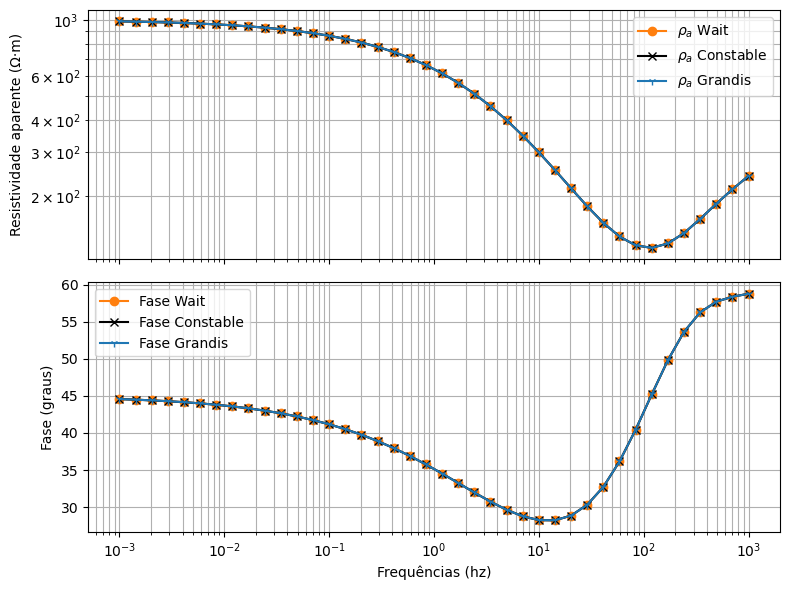

In [197]:
# Convertendo para período (em segundos)
# periodos = 1 / frequencias

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Resistividade aparente
ax[0].loglog(frequencias, rho_a_wait, marker='o',color='tab:orange', label='$ρ_a$ Wait')
ax[0].loglog(frequencias, rho_a_constable, marker='x',color='black', label='$ρ_a$ Constable')
ax[0].loglog(frequencias, rhoa_grandis, marker='1', label='$ρ_a$ Grandis')

ax[0].set_ylabel('Resistividade aparente (Ω·m)')
ax[0].grid(True, which='both')
ax[0].legend()

# Fase
ax[1].semilogx(frequencias, fase_wait, marker='o', color='tab:orange',
               label='Fase Wait')
ax[1].semilogx(frequencias, phi_constable, marker='x', color='black', 
               label='Fase Constable')
ax[1].semilogx(frequencias, phase_grandis, marker='1', color='tab:blue', 
               label='Fase Grandis')
# ax[1].semilogx(frequencias, fase_wait, marker='o', color='tab:orange', label='Fase wait')

ax[1].set_xlabel('Frequências (hz)')
ax[1].set_ylabel('Fase (graus)')
ax[1].grid(True, which='both')
ax[1].legend()

plt.tight_layout()
plt.show()
